# Searching data bases

This notebook shows a few examples of how to search astronomical databases programatically.

In [41]:
import numpy as np
from matplotlib import pyplot as plt
# import ipywidgets as widgets

In [42]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia  
from astroquery.simbad import Simbad
from astropy.table import Table

# Simbad

Using Simbad or one of its sub-services such as Vizier is pretty much unavoidable for an astronomer. Astroquery can help you with that (although if you are looking for one object I would go to the web page!):

In [43]:
c = SkyCoord("05h35m17.3s -05d23m28s", frame='icrs')
r = 2*u.arcmin

result = Simbad.query_region(c, radius=r)
print(result)

           MAIN_ID                   RA           DEC      RA_PREC ... COO_QUAL COO_WAVELENGTH     COO_BIBCODE     SCRIPT_NUMBER_ID
                                  "h:m:s"       "d:m:s"            ...                                                             
------------------------------ ------------- ------------- ------- ... -------- -------------- ------------------- ----------------
               NAME Ori Region   05 35 17.30   -05 23 28.0       6 ...        D              O                                    1
                 [FRM2016] 344 05 35 17.2210 -05 23 26.542       9 ...        C              R 2016ApJ...822...93F                1
                DOH  7 175-328    05 35 17.5     -05 23 28       5 ...        D                2004AJ....127.3456D                1
                       MAX 126   05 35 17.11   -05 23 29.3       6 ...        D              I 2005AJ....129.1534R                1
                DOH  7 171-327    05 35 17.1     -05 23 27       5 ...      

# JWST

There are several ways to search for JWST data - you can use the MAST service both online and through astroquery, and search through the ESA JWST archive. Here we search for Trappist 1. 

In [44]:
from astroquery.esa.jwst import Jwst
Jwst.get_status_messages() # Recommended to do before sending a query

In [45]:
ra_trappist1 = "23h06m29.368s"
dec_trappist1 = "-05d02m29.04"
coord = SkyCoord(ra=ra_trappist1, dec=dec_trappist1, frame='icrs')

In [46]:
j = Jwst.cone_search(coordinate=coord, radius=0.5*u.arcmin, async_job=True)

INFO: Query finished. [astroquery.utils.tap.core]


In [47]:
result = j.get_results()

In [48]:
len(result['instrument_name'])

546

### Task: 
If you have time, combine the two approaches to find how many observations have been made of the Red Rectangle planetary nebula with JWST.

In [86]:
res = Simbad.query_object("Red Rectangle")

In [50]:
ra_rr = res['RA'][0]
dec_rr = res['DEC'][0]
coord_rr = SkyCoord(ra=ra_rr, dec=dec_rr, unit=(u.hourangle, u.deg), frame='icrs')

In [51]:
j_rr = Jwst.cone_search(coordinate=coord_rr, radius=0.5*u.arcmin, async_job=True)


INFO: Query finished. [astroquery.utils.tap.core]


In [52]:
result = j_rr.get_results()
print("Number of observations = {0}".format(len(result)))

Number of observations = 102


# Gaia

## Getting an overview of tables

It is imperative to get to know what tables are available in a database - without that it is impossible to create searches. We would normally read the documentation for the archive, but here is a way to print all tables.

In [78]:
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print (table.get_qualified_name())    

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
external.external.apassdr9
external.external.catwise2020
external.external.gaiadr2_astrophysical_parameters
external.external.gaiadr2_geometric_distance
external.external.gaiaedr3_distance
external.external.gaiaedr3_gcns_main_1
external.external.gaiaedr3_gcns_rejected_1
external.external.gaiaedr3_spurious
external.external.gaia_eso_survey
external.external.galex_ais
external.external.lamost_dr9_lrs
external.external.lamost_dr9_mrs
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
external.external.ravedr6
external.external.sdssdr13_photoprimary
external.external.skymapperdr1_master
external.external.skymapperdr2_master
external.external.tmass_xsc
external.external.xgboost_table1
external.external.xgboost_table2
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_ze

what you will see here is that there is a lot of repetition - we see both gaiadr2 and gaiadr3 etc. Clearly this is not all we want. So the best is to go to the [Gaia archive](https://www.cosmos.esa.int/web/gaia-users/archive#) - this link is to the documentation. The full structure is recorded in what is called the data model. 

In the end, however, what you need here is the `gaia_source` table and I will also get this for data release 3 (dr3, currently the latest release). To be concrete, let us search around te centre of the Hyades star cluster. The search will take a bit of time, so we launch it as an asynchronous search and ask for it to be dumped to disk

In [101]:
search_radius = 6.0/2.0 # In degrees
# The position of the Hyades cluster
res = Simbad.query_object("Hyades")
c = SkyCoord(ra=res['RA'][0], dec=res['DEC'][0], unit=(u.hourangle, u.deg))
ra_pos = c.ra.deg
dec_pos = c.dec.deg

query = "SELECT * FROM gaiadr3.gaia_source WHERE DISTANCE(ra,dec,{0:.5f},{1:.5f}) <{2:.1f}".format(ra_pos, dec_pos, search_radius)
job   = Gaia.launch_job_async(query, dump_to_file=True)
print (job)



In [102]:
# The tables are stored on disk as VOT tables with peculiar naming. It is a good idea to rename these
# to something a bit more useful - although if you are doing something more complex and important you 
# should store a record of what you did. I have renamed my result to Hyades-Gaia-search.vot.gz  - 
# If you are in Google Colab this is not helpful because the file would be delete each time you restart 
# the Colab but for now it is fine. I also converted it to FITS for speeding up.
t = Table().read('Hyades-Gaia-search.fits')

In [103]:
len(t)

261377

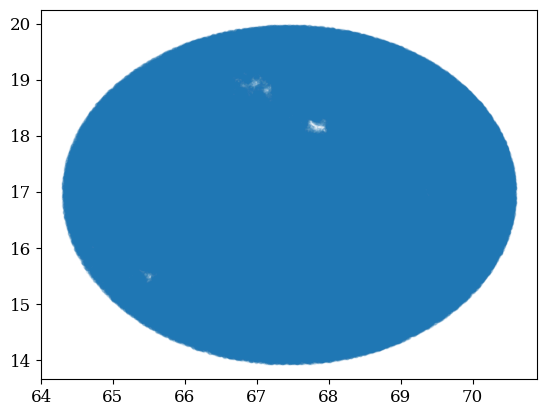

In [104]:
plt.scatter(t['ra'], t['dec'], marker='.', alpha=0.1)

The Hyades is pretty close at a distance of 47 pc, so let us select stars at that distance

In [105]:
is_hyades, = np.where(np.abs(t['distance_gspphot']-47) < 10)

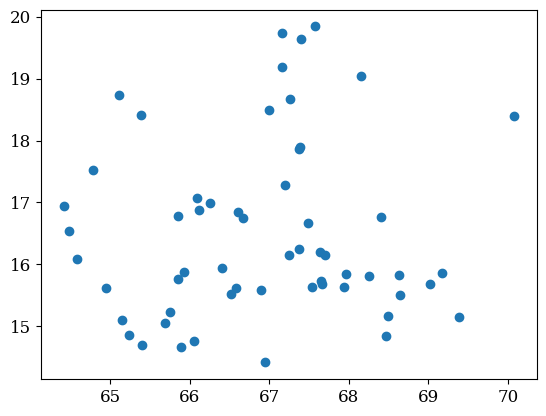

In [106]:
plt.scatter(t['ra'][is_hyades], t['dec'][is_hyades])

In [120]:
ii, = np.where( (t['parallax']/1e3 > 1.0/(47.0+10.0)) & (t['parallax']/1e3 < 1.0/(47.0-10.0)) & (t['parallax']/t['parallax_error'] > 3))

In [121]:
len(ii)

188

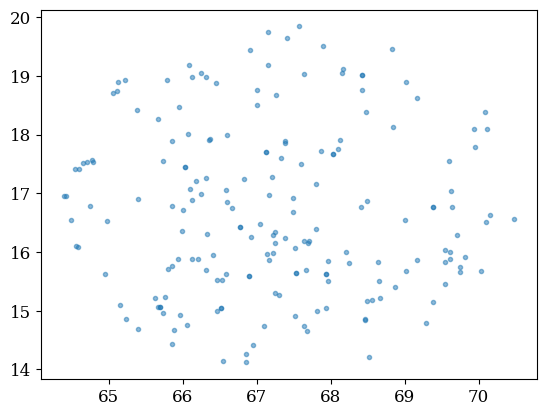

In [123]:
plt.scatter(t['ra'][ii], t['dec'][ii], marker='.', alpha=0.5)